In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/application_train.csv


In [3]:
train = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
test = pd.read_csv("/kaggle/input/home-credit-default-risk/application_test.csv")
sample_submission = pd.read_csv("/kaggle/input/home-credit-default-risk/sample_submission.csv")

In [4]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [5]:
kf = KFold(n_splits=5)
kf.get_n_splits(train)

features = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE',
            'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2']

In [14]:
# n_estimators variation

n_estimators_list = []
n_estimators_roc_auc = []

for estimators in range(100, 1000, 100):
    roc_auc_list = []

    model = LGBMClassifier(n_estimators = estimators, max_depth = 3, num_leaves = 5)

    for i, (train_index, test_index) in enumerate(kf.split(train)):

        X_train, X_test = train.loc[train_index, features], train.loc[test_index, features ]
        y_train, y_test = train.loc[train_index, 'TARGET'], train.loc[test_index, 'TARGET']

        model.fit(X_train, y_train)
        predict = model.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, predict)
        roc_auc_list.append(roc_auc)
    
    n_estimators_list.append(estimators)
    n_estimators_roc_auc.append(np.mean(roc_auc_list))

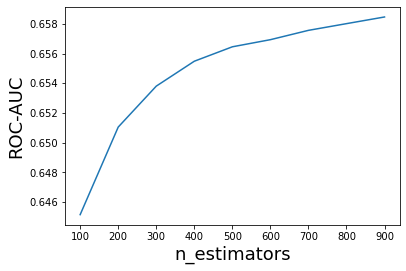

In [15]:
plt.plot(n_estimators_list, n_estimators_roc_auc)
plt.ylabel('ROC-AUC', fontsize=18)
plt.xlabel('n_estimators', fontsize=18)
plt.show()

In [16]:
# max_depth variation

max_depth_list = []
max_depth_roc_auc = []

for max_depth in range(2, 10):
    roc_auc_list = []

    model = LGBMClassifier(n_estimators = 500, max_depth = max_depth, num_leaves = 5)

    for i, (train_index, test_index) in enumerate(kf.split(train)):

        X_train, X_test = train.loc[train_index, features], train.loc[test_index, features ]
        y_train, y_test = train.loc[train_index, 'TARGET'], train.loc[test_index, 'TARGET']

        model.fit(X_train, y_train)
        predict = model.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, predict)
        roc_auc_list.append(roc_auc)
    
    max_depth_list.append(max_depth)
    max_depth_roc_auc.append(np.mean(roc_auc_list))

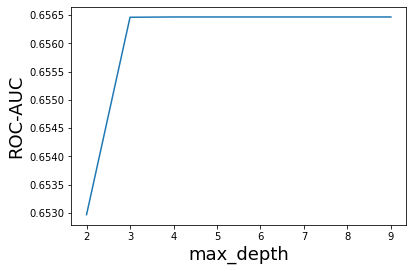

In [17]:
plt.plot(max_depth_list, max_depth_roc_auc)
plt.ylabel('ROC-AUC', fontsize=18)
plt.xlabel('max_depth', fontsize=18)
plt.show()

In [20]:
# num_leaves variation

num_leaves_list = []
num_leaves_roc_auc = []

for num_leaves in range(2, 10):
    roc_auc_list = []

    model = LGBMClassifier(n_estimators = 500, max_depth = 3, num_leaves = num_leaves)

    for i, (train_index, test_index) in enumerate(kf.split(train)):

        X_train, X_test = train.loc[train_index, features], train.loc[test_index, features ]
        y_train, y_test = train.loc[train_index, 'TARGET'], train.loc[test_index, 'TARGET']

        model.fit(X_train, y_train)
        predict = model.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, predict)
        roc_auc_list.append(roc_auc)
    
    num_leaves_list.append(num_leaves)
    num_leaves_roc_auc.append(np.mean(roc_auc_list))

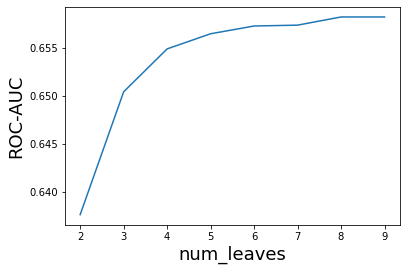

In [21]:
plt.plot(num_leaves_list, num_leaves_roc_auc)
plt.ylabel('ROC-AUC', fontsize=18)
plt.xlabel('num_leaves', fontsize=18)
plt.show()

In [6]:
# Data preparation

# Empty fields fulfillment

train.fillna(method = "ffill", inplace = True)
test.fillna(method = "ffill", inplace = True)

# NaN's removement

train = train.dropna()
train = train.reset_index(drop=True)

In [27]:
# GridSearchCV usage

from sklearn.model_selection import GridSearchCV

params_grid = [
    {"n_estimators": np.arange(100, 400, 100)},
    {"max_depth": np.arange(2, 4)},
    {"num_leaves": np.arange(2, 4)},
]

gs = GridSearchCV(LGBMClassifier(), param_grid = params_grid, scoring = 'roc_auc')

gs.fit(train[features], train["TARGET"])

print(gs.best_params_, gs.best_score_)

{'n_estimators': 200} 0.6591244640217019


In [29]:
# RandomizedSearchCV usage

from sklearn.model_selection import RandomizedSearchCV

params_grid = [
    {"n_estimators": np.arange(100, 400, 100)},
    {"max_depth": np.arange(2, 4)},
    {"num_leaves": np.arange(2, 4)},
]

rs = RandomizedSearchCV(LGBMClassifier(), param_distributions = params_grid, scoring = 'roc_auc')
rs.fit(train[features], train["TARGET"])

print(rs.best_params_, rs.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'n_estimators': 200} 0.6591244640217019


In [7]:
# Categorical features encoding

from sklearn import preprocessing

categorical_fields = []

for col, col_type in dict(train.dtypes).items():
    if col_type == object:
        categorical_fields.append(col)
        
for col in categorical_fields:
    train_encoder = preprocessing.LabelEncoder()
    train[col] = train_encoder.fit_transform(train[col])
    
    test_encoder = preprocessing.LabelEncoder()
    test[col] = test_encoder.fit_transform(test[col].astype(str))

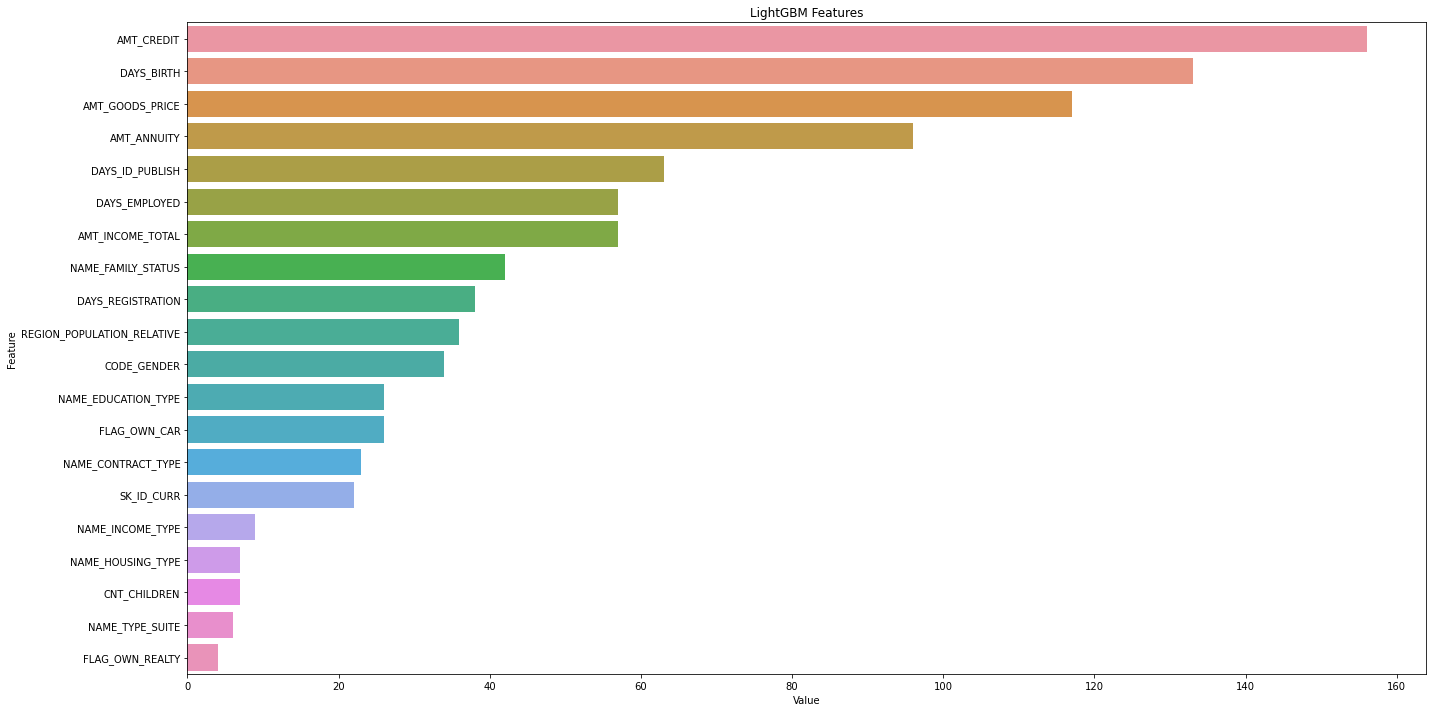

In [9]:
# Features importance

import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

all_features = list(train.columns)
all_features.remove("TARGET")

model = LGBMClassifier(n_estimators = 500, max_depth = 3, num_leaves = 5)
model.fit(train[all_features], train["TARGET"])

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,all_features[:20])), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [11]:
# Stacking

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

estimators = [
    ("lgbm_1", LGBMClassifier(n_estimators = 500, max_depth = 3, num_leaves = 5)),
    ("lgbm_2", LGBMClassifier(n_estimators = 900, max_depth = 3, num_leaves = 9)),
    ("rf_1", RandomForestClassifier(max_depth = 3, max_features = 3, max_leaf_nodes = 2)),
    ("rf_2", RandomForestClassifier(max_depth = 3, max_features = 3, max_leaf_nodes = 5)),
    ("logreg", LogisticRegression(max_iter=1000)),
]

clf = StackingClassifier(estimators = estimators, final_estimator=LogisticRegression())

X_train, X_test, y_train, y_test = train_test_split(train[all_features], train["TARGET"], stratify=train["TARGET"], random_state=42)

clf.fit(X_train, y_train).score(X_test, y_test)

0.9187543900725825

In [12]:
estimators = [
    ("lgbm_1", LGBMClassifier(n_estimators = 500, max_depth = 3, num_leaves = 5)),
    ("lgbm_2", LGBMClassifier(n_estimators = 900, max_depth = 3, num_leaves = 9)),
    ("rf_1", RandomForestClassifier(max_depth = 3, max_features = 3, max_leaf_nodes = 2)),
    ("logreg", LogisticRegression(max_iter=1000)),
]

clf = StackingClassifier(estimators = estimators, final_estimator=LogisticRegression())

X_train, X_test, y_train, y_test = train_test_split(train[all_features], train["TARGET"], stratify=train["TARGET"], random_state=42)

clf.fit(X_train, y_train).score(X_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


KeyboardInterrupt: 